In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from modsim import get_first_label, get_last_label, plot, decorate, System, linrange, TimeSeries
import seaborn as sns; sns.set()
%matplotlib inline

Using SimPy, write a process simulation that includes waiting time (discrete event simulation).  You may use any topic of interest to you.  Write the simulation and all of the following in Jupyter.

Each element is worth 5 points and will be graded using the rubric shown here.

1.  State the problem and its significance.

2.  Provide a flow-chart model. 

3.  Simulate the process for the appropriate number of iterations (justify)

4.  Justify the validity of the model and discuss how you verified it.

5.  State  your conclusions/ findings from the model. 

6.  Generate appropriate graphs (more than one) to illustrate the results and provide a PowerPoint presentation to share with your colleagues.  Post this to the discussion. 

All data gotten from
https://apps.bea.gov/iTable/iTable.cfm?reqid=19&step=3&isuri=1&nipa_table_list=6&categories=survey

GDP = Consumption + Investment + Gov Expenditure + (Exports - Imports)

In [45]:
gdp_cols = {'Gross domestic product': 'gdp', 'Personal consumption expenditures': 'consumption', 'Gross private domestic investment': 'investment', 'Net exports of goods and services': 'ex_im', 'Government consumption expenditures and gross investment': 'gov_exp'}

In [46]:
df = pd.read_csv('us_gdp_1990_2020.csv')\
            .rename(columns={'Unnamed: 1': 'components'})\
            .assign(components=lambda x: x['components'].str.strip().map(gdp_cols))\
            .dropna(how='all', axis=0)

In [47]:
df = df[df['components'].isin(gdp_cols.values())].pivot_table(columns='components')[['consumption', 'investment', 'gov_exp', 'ex_im', 'gdp']]

In [48]:
df

components,consumption,investment,gov_exp,ex_im,gdp
2002,9088.7,2195.5,2885.2,-667.3,13493.1
2003,9377.5,2290.4,2947.2,-735.0,13879.1
2004,9729.3,2502.6,2992.7,-841.4,14406.4
2005,10075.9,2670.6,3015.5,-887.8,14912.5
2006,10384.5,2752.4,3063.5,-905.0,15338.3
2007,10615.3,2684.1,3118.6,-823.6,15626.0
2008,10592.8,2462.9,3195.6,-661.6,15604.7
2009,10460.0,1942.0,3307.3,-484.8,15208.8
2010,10643.0,2216.5,3307.2,-565.9,15598.8
2011,10843.8,2362.1,3203.3,-568.1,15840.7


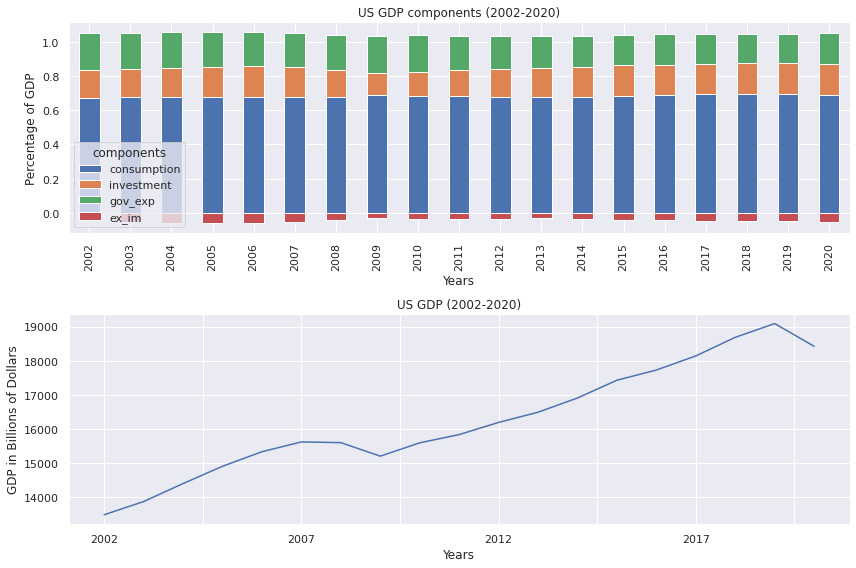

In [49]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
df.div(df['gdp'], axis=0).drop(['gdp'], axis=1).plot.bar(title='US GDP components (2002-2020)', xlabel='Years', ylabel='Percentage of GDP', ax=ax[0], stacked=True)
df['gdp'].plot(title='US GDP (2002-2020)', xlabel='Years', ylabel='GDP in Billions of Dollars', ax=ax[1])
plt.tight_layout()

From the plots above we can see `consumption` is the largest contributor to the US `gdp` followed by `investment` and `government spending`, `exports and imports` makes up the smallest component.

In [50]:
t_0 = get_first_label(df)
t_end = get_last_label(df)
c_0, i_0, g_0, ei_0, gdp_0 = df.loc[t_0].values

In [51]:
system = System(t_0=int(t_0),
                t_end=int(t_end),
                consumption=c_0,
                investment=i_0,
                gov_expenditure=g_0,
                ex_im=ei_0,
                gdp=gdp_0)
system

,values
t_0,2002.0
t_end,2020.0
consumption,9088.7
investment,2195.5
gov_expenditure,2885.2
ex_im,-667.3
gdp,13493.1


In [84]:
def update_func(gdp, t, system):
    """
    Determine growth rates for c, i, g, ex
    """
    if t <2008:
        growth_params = {'consumption': 0.02, 'investment': 0.02, 'gov_expenditure': 0.01, 'ex_im': -0.005}
    else:
        growth_params = {'consumption': 0.025, 'investment': 0.02, 'gov_expenditure': 0.03, 'ex_im': -0.01}
    gdp_growth = 0
    for k, v in growth_params.items():
        gdp_growth += system[k] * v
    #import pdb; pdb.set_trace()
    return gdp + gdp_growth

In [85]:
def run_simulation(system, update_func):

    results = TimeSeries()
    results[system.t_0] = system.gdp
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = update_func(results[t], t, system)
        
    return results

In [86]:
results = run_simulation(system, update_func)

<AxesSubplot:>

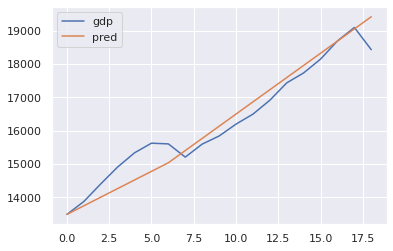

In [87]:
pd.concat([df['gdp'].reset_index(), results.to_frame('pred').reset_index()], axis=1).drop(['index'], axis=1).plot()